In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(1337)

# Load and process the data
aggregate_df1 = pd.read_csv('/home/awinlab/Documents/kevin/elec110.csv', index_col='datetime', parse_dates=True)
aggregate_df1 = aggregate_df1[:900000]

plug1_1 = pd.read_csv('/home/awinlab/Documents/kevin/plug1-3.csv', index_col='datetime', parse_dates=True)
plug1_1 = plug1_1[:900000]

aggregate_df1 = aggregate_df1.drop(['Unnamed: 0','id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)
plug1_1 = plug1_1.drop(['Unnamed: 0','id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)

/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, length=100):
        self.X = X
        self.y = y
        self.length = length

    def __len__(self):
        return len(self.X) - self.length

    def __getitem__(self, idx):
        X = self.X[idx: idx + self.length]
        y = self.y[idx: idx + self.length]
        return X, y

mask = [i % 5 != 0 for i in range(len(aggregate_df1))]
X_train = aggregate_df1[~np.array(mask)]
X_test = aggregate_df1[mask]



mask1 = [i % 5 != 0 for i in range(len(plug1_1))]
y_train = plug1_1[~np.array(mask1)]
y_test = plug1_1[mask1]

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()


In [4]:
batch_size=60

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0, drop_last = True, 
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0, drop_last = True,
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

In [5]:
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=4):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(nn.Conv1d(in_planes, in_planes // ratio, 1, bias=False),
                                nn.ReLU(),
                                nn.Conv1d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)
    
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv1d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

    
class ConvolutionalModel(nn.Module):
    def __init__(self, input_shape, n_input):
        super().__init__()
        sequence_length = 60
        self.conv = nn.Sequential(
            nn.ConstantPad1d((4, 5), 0),
            nn.Conv1d(100, 30, 10, stride=1),
            nn.ReLU(True),
            nn.ConstantPad1d((3, 4), 0),
            nn.Conv1d(30, 30, 8, stride=1),
            nn.ReLU(True),
            nn.ConstantPad1d((2, 3), 0),
            nn.Conv1d(30, 40, 6, stride=1),
            nn.ReLU(True),
            nn.ConstantPad1d((2, 2), 0),
            nn.Conv1d(40, 50, 5, stride=1),
            nn.ReLU(True),
            nn.ConstantPad1d((2, 2), 0),
            nn.Conv1d(50, 50, 5, stride=1),
            nn.ReLU(True)
        )

        self.ca = ChannelAttention(in_planes=50, ratio=4)
        self.sa = SpatialAttention(kernel_size=7)

        self.dense = nn.Sequential(
            nn.Linear(50, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1)
        )

    def forward(self, x):  # [2,1,129] [,,seq_length]
        x = self.conv(x)  # [2,50,129]
        x = self.ca(x) * x
        x = self.sa(x) * x
        x = x.view(x.size(0), -1)
        x = self.dense(x)
        return x

n_input = 100
input_shape = (n_input, 1)
model = ConvolutionalModel(input_shape, n_input)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
mae_fn = nn.L1Loss()

In [6]:
model = model.to(device)
loss_fn = loss_fn.to(device)
mae_fn = mae_fn.to(device)

In [7]:
def rete(y_true, y_pred):
    y_true = y_true.view(-1, 1)
    y_pred = y_pred.view(-1, 1)

    # Compute the maximum value between y_true and y_pred element-wise, and reshape it to have shape (batch_size*seq_len, 1)
    max_val, _ = torch.max(torch.cat([y_pred, y_true], dim=1), dim=1, keepdim=True)

    # Compute the relative error between y_true and y_pred element-wise, and reshape it to have shape (batch_size*seq_len, 1)
    rel_err = torch.abs(y_pred - y_true) / max_val

    # Take the mean of the relative error across all samples in the batch
    return torch.mean(rel_err)

In [8]:
from torch.nn import L1Loss
import matplotlib.pyplot as plt
import tqdm



num_epochs = 5

for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(tqdm.tqdm(train_loader)):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch) 
        loss = loss_fn(y_pred.view(-1), y_batch.view(-1,1))
        mae = mae_fn(y_pred.view(-1), y_batch.view(-1,1))
        rete_val = rete(y_batch[:,0,:].view(-1,1), y_pred.view(-1,1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    tqdm.tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item()}, MAE: {mae.item()}, Rete: {rete_val.item()}")


  0%|                                                  | 0/2998 [00:00<?, ?it/s]/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([6000, 1])) that is different to the input size (torch.Size([60])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([6000, 1])) that is different to the input size (torch.Size([60])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████████████████████████████████| 2998/2998 [00:22<00:00, 132.87it/s]


Epoch [1/5], Step [2997/2998], Loss: 3.0969083582021995e-06, MAE: 0.0014500790275633335, Rete: inf


100%|██████████████████████████████████████| 2998/2998 [00:22<00:00, 133.07it/s]


Epoch [2/5], Step [2997/2998], Loss: 0.14283742010593414, MAE: 0.377926230430603, Rete: 1.0


100%|██████████████████████████████████████| 2998/2998 [00:22<00:00, 132.20it/s]


Epoch [3/5], Step [2997/2998], Loss: 0.0934152603149414, MAE: 0.3055993318557739, Rete: 1.0


100%|██████████████████████████████████████| 2998/2998 [00:21<00:00, 137.86it/s]


Epoch [4/5], Step [2997/2998], Loss: 1.5095459275471512e-05, MAE: 0.0032763767521828413, Rete: inf


100%|██████████████████████████████████████| 2998/2998 [00:18<00:00, 161.50it/s]

Epoch [5/5], Step [2997/2998], Loss: 1.5392333807540126e-06, MAE: 0.0010239549446851015, Rete: inf


In [9]:
predict = []
model = model.cpu()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predict.append(outputs)

In [10]:
predict_list = np.concatenate([p.detach().numpy() for p in predict], axis=0)

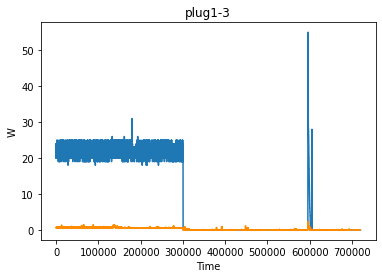

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(facecolor='white')
plt.plot(y_test)
plt.plot(predict_list,color='darkorange')
plt.xlabel('Time')
plt.ylabel("W")
plt.title("plug1-3")
plt.savefig('/home/awinlab/Documents/kevin/AttentionCNN/pytorch/AttentionCNN_plug1-3.png')
plt.show()